# 6.1 Dummy Coding

Dummy coding enables the comparison of each category of a categorical variable to a reference category, which serves as the baseline for measuring the effects of the other categories. In this coding scheme, the reference category is assigned a value of 0 (corresponding to the intercept), while the dummy variables for the remaining categories are assigned values of either 1 or 0. 

To implement dummy coding, we will use a combination of the `patsy` and `statsmodels` package, as this provides straightforward and customizable options, particularly for defining the reference category.

First, we will import the essential libraries needed to visualize the data.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

Then we load the data (in this case from a local file) and have a look at it:

In [2]:
df = pd.read_csv("data/alzheimers_data.txt", delimiter='\t').dropna()
print(df.head())

   subject  sex  age       WMv       WMn       WMf    SMv    SMn       SMf  \
0   111000    1   29  0.655556  0.604762  0.707143  0.425  0.225  0.333333   
1   111001    1   23  0.506667  0.642857  0.846429  0.450  0.100  0.375000   
2   111002    1   24  0.602222  0.571429  0.744048  0.650  0.425  0.166667   
3   111003    1   33  0.616667  0.692857  0.857143  0.500  0.225  0.250000   
4   111004    1   29  0.884444  0.677381  0.871429  0.600  0.200  0.583333   

       Spd1      Spd2      Spd3      Spd4     gfv     gfn     gff  APOE   e4  \
0  2.603213  2.272891  2.324883  2.460446  0.5625  0.3750  0.3750   6.0  0.0   
1  2.063279  2.017480  1.904249  1.978650  0.1875  0.4375  0.3750   1.0  1.0   
2  2.075107  2.085463  1.902517  1.986161  0.4375  0.6250  0.3125   3.0  1.0   
3  2.384937  2.246979  2.157284  2.243270  0.5625  0.5625  0.3125   1.0  1.0   
4  1.733822  1.485727  1.963233  1.898097  0.6250  0.4375  0.4375   1.0  1.0   

  genotype  
0    e4/e4  
1    e3/e3  
2    e2/e3 

We then make sure that the `genotype` is treated as a categorical variable. For this, we first check its type:

In [3]:
# Since we are working with a pandas dataframe, we can use the 
# method ".dtypes" to extract the data type of each column.

data_types = df.dtypes
print(data_types)

subject       int64
sex           int64
age           int64
WMv         float64
WMn         float64
WMf         float64
SMv         float64
SMn         float64
SMf         float64
Spd1        float64
Spd2        float64
Spd3        float64
Spd4        float64
gfv         float64
gfn         float64
gff         float64
APOE        float64
e4          float64
genotype     object
dtype: object


We see that it is of type `object`, which is typical for strings. However, for categorical regression, we need to change it to type `category` using `.astype('category')`:

In [4]:
df['genotype'] = df['genotype'].astype('category')
print(df["genotype"].dtypes)

category


Great, that worked well. We can now proceed to plot the genotypes as individual boxplots against figural working memory ability:`WMf`. For this we will use `seaborn` boxplots, as they are easy to use with data frames:

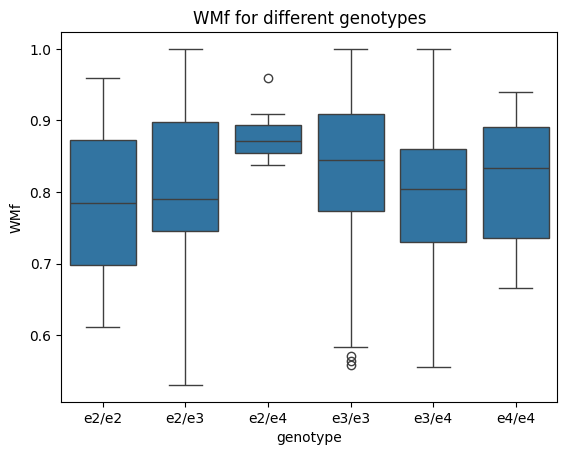

In [5]:
sns.boxplot(x='genotype', y='WMf', data=df)
plt.title("WMf for different genotypes")
plt.show()

We can then perform categorical regression with dummy coding. For this, we use `statsmodels` combined with the `Treatment` function from the `patsy` package:

In [6]:
from patsy.contrasts import Treatment

model = smf.ols('WMf ~ C(genotype, Treatment(reference="e4/e4"))', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    WMf   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     2.605
Date:                Wed, 09 Apr 2025   Prob (F-statistic):             0.0257
Time:                        08:52:59   Log-Likelihood:                 219.06
No. Observations:                 245   AIC:                            -426.1
Df Residuals:                     239   BIC:                            -405.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

## Interpreting the Output

When you run the regression `WMf ~ C(genotype, Treatment(reference="e4/e4"))`, the output provides the following key pieces of information:

1. **Intercept**:
    - This is the mean value of `WMf` for the reference group (`e4/e4` in this case).
    - For example, if the intercept is 0.8185, it indicates that the average `WMf` for the `e4/e4` group is 0.8185.

2. **Slopes** for Dummy Variables (`C(genotype)[T.<level>]`):
    - Each slope represents the difference in the mean value of `WMf` between the respective `genotype` group and the reference group (`e4/e4`).
    - For example, if `C(genotype)[T.e2/e2]` has a coefficient of -0.0333:
      - The mean `WMf` for the `e2/e2` group is 0.0333 less than the mean for the `e4/e4` group.

3. **Regression Equation**:
    - The regression equation summarizes the relationship between the predictors (`genotype` groups) and the outcome (`WMf`) by filling in the intercept and the slope specific to each genotype, derived from the output:

$$\hat{Y} = 0.82 - 0.03 * e2/e2 - 0.02 * e2/e3 + 0.06 * e2/e4 + 0.02 * e3/e3 - 0.03 * e3/e4$$

4. **Statistical Significance**:
    - The p-values for each coefficient test whether the difference between the respective group and the reference group is statistically significant.
    - For example:
      - If `p = 0.668` for `C(genotype)[T.e2/e2]`, it indicates that the mean `WMf` for the `e2/e2` group is not significantly different from the `e4/e4` group, as this p-value is above any reasonable significance threshold (e.g., 0.05).

5. **R-squared** and Model Fit:
    - The R-squared value indicates how much of the variation in `WMf` is explained by the genotype categories. A higher R-squared value suggests a strong relationship between `genotype` and `WMf`.

## The Contrast Matrix

For dummy coding, there is usually no need to manually create dummy variables or to create a contrast matrix, as `statsmodels` handles this automatically. However, to ensure that we did everything correctly, we can manually create the contrast matrix and have a look at it:

In [7]:
# Get all genotype levels and save them as a list
levels = df['genotype'].cat.categories.tolist()

# Create a Treatment contrast matrix
contrast = Treatment(reference="e4/e4").code_without_intercept(levels)

print("Levels:", levels)
print("Contrast Matrix:\n", contrast.matrix)

Levels: ['e2/e2', 'e2/e3', 'e2/e4', 'e3/e3', 'e3/e4', 'e4/e4']
Contrast Matrix:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


```{admonition} Summary
:class: tip
- In dummy coding, the reference category is assigned a value of 0
- You can use `model = smf.ols('WMf ~ C(outcome, Treatment(reference="your reference"))', data=my_data)` for dummy coding
```